In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import autograd

from IPython.display import clear_output
from PIL import Image

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

### Load data

In [2]:
big_img = np.asarray(Image.open('initial.jpg'))/255.0

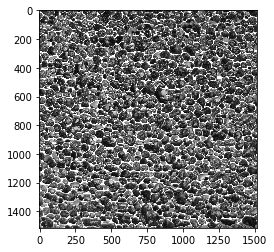

In [3]:
plt.imshow(big_img)

In [4]:
size = big_img.shape[:2]
#big_img = big_img[:size,:size]

In [5]:
np.mean(big_img.reshape(-1, size[0]*size[1]), axis=1)

array([0.53784   , 0.5454145 , 0.56411937, 0.55184983])

In [6]:
np.std(big_img.reshape(-1, size[0]*size[1]), axis=1)

array([0.35350815, 0.35309984, 0.34657819, 0.34701005])

In [7]:
use_cuda = True
batch_size = 32

#big_img.transpose()

#transform = transforms.Compose([transforms.ToTensor(), 
#                               transforms.Normalize(mean=[0.4851, 0.4725, 0.4512], 
#                                                    std=[0.1797, 0.1848, 0.1808])])
transform = transforms.ToTensor()
big_input = transform(big_img)

#big_input = torch.from_numpy(big_img[None,:,:])
big_repeated = big_input[None,:,:,:].repeat(batch_size, 1, 1, 1)


if use_cuda:
    #small_inputs = small_inputs.cuda()
    big_repeated = big_repeated.cuda()

In [8]:
#generator_inputs = torch.from_numpy(small_imgs[:,None,:,:])
def generate_noise(size):
    return torch.randn(size)

In [9]:
def calculate_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.shape[0], 1,1,1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if use_cuda else alpha

    interpolates = alpha * real_data.data + ((1 - alpha) * fake_data.data)

    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
noise_DIM = 20
small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)

In [15]:
def build_grid(source_size,target_size):
    k = float(target_size)/float(source_size)
    direct = torch.linspace(0,k,target_size).unsqueeze(0).repeat(target_size,1).unsqueeze(-1)
    full = torch.cat([direct,direct.transpose(1,0)],dim=2).unsqueeze(0)
    return full.cuda()

def random_crop_grid(x,grid):
    delta = x.size(2)-grid.size(1)
    grid = grid.repeat(x.size(0),1,1,1).cuda()
    #Add random shifts by x
    grid[:,:,:,0] = grid[:,:,:,0]+ torch.FloatTensor(x.size(0)).cuda().random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2)
    #Add random shifts by y
    grid[:,:,:,1] = grid[:,:,:,1]+ torch.FloatTensor(x.size(0)).cuda().random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2)
    return grid

In [16]:
grid_source = build_grid(big_repeated.size(2), small_height)
#Make radom shift for each batch
grid_shifted = random_crop_grid(big_repeated,grid_source)
#Sample using grid sample
sampled_batch = F.grid_sample(big_repeated, grid_shifted.double())

In [17]:
def generate_batch(big_input, batch_size, small_width, small_height):
    output = torch.zeros((batch_size, img_DIM, small_width, small_height))
    indices = np.random.randint(0, big_input.shape[1] - small_height, size = (batch_size, 2))
    for i in range(batch_size):
        x, y = indices[i]
        output[i] = big_input[:,x:x+small_height, y:y+small_width]
    return output

In [18]:
discr_input = generate_batch(big_input, batch_size, small_width, small_height)

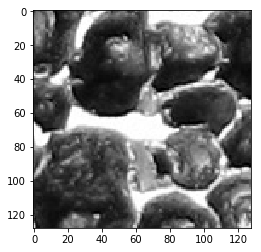

In [19]:
plt.imshow(discr_input[0].data.cpu().permute(1,2,0).numpy().squeeze())

# continue here

In [60]:
#noise_DIM = 20
#small_width, small_height = 128, 128

conv_num = 256

img_DIM = big_img.shape[-1]

k_size = (5,5)


d_l = 20
d_g = 3 
d_p = 10
d_h = 10

noise_DIM = d_l+d_g+d_p

n = 2
tmp = small_height-1
for i in range(n+2):
    tmp = (tmp-1)//2
linear_input_size = tmp**2*noise_DIM

In [61]:
def generate_noise(size):
    return -1+2*torch.rand(size)

In [62]:
class Noise(nn.Module):
    def __init__(self, d_l, d_g, d_p, d_h):
        super(Noise, self).__init__()
        self.d_l = d_l
        self.d_g = d_g
        #self.size = size
        self.d_p = d_p
        if self.d_g != 0 and self.d_p != 0:
            self.fc1 = nn.Linear(d_g, d_h)
            self.fc2 = nn.Linear(d_h, d_p)
            self.fc3 = nn.Linear(d_h, d_p)
        
            nn.init.xavier_normal_(self.fc1.weight)
            nn.init.xavier_normal_(self.fc2.weight)
            nn.init.xavier_normal_(self.fc3.weight)
            nn.init.constant_(self.fc1.bias, 0.01)
            nn.init.constant_(self.fc2.bias, 0.01)
            nn.init.constant_(self.fc3.bias, 0.01)
        
    def forward(self, size):
        #z_l = -1+2*torch.rand([x.shape[0], self.d_l, self.size[0], self.size[1]])
        
        if self.d_p == 0:   #  d_p + d_g + d_l != 0
            if self.d_g == 0:
                #print(1)
                z_l = -1+2*torch.rand([batch_size, self.d_l, size[0], size[1]])
                if use_cuda:
                    z_l = z_l.cuda()
                return z_l
            elif self.d_l == 0:
                z_g = -1+2*torch.rand([batch_size, self.d_g])
                z_g = z_g[:,:,None, None].repeat(1, 1, size[0], size[1])
                if use_cuda:
                    z_g = z_g.cuda()
                return z_g
            else:
                z_l = -1+2*torch.rand([batch_size, self.d_l, size[0], size[1]])
                z_g = -1+2*torch.rand([batch_size, self.d_g])
                z_g = z_g[:,:,None, None].repeat(1, 1, size[0], size[1])
                if use_cuda:
                    z_g = z_g.cuda()
                    z_l = z_l.cuda()                    
                return torch.cat([z_l, z_g], dim = 1)
        else:
            if self.d_g == 0:
                z_p_1 = Variable(torch.ones(1)*0.01).float()
                z_p_2 = Variable(torch.ones(1)*0.01).float()
                phi = torch.rand([batch_size, self.d_p])
                
                xx = torch.linspace(0,size[0], steps=size[0], dtype=torch.float32)
                yy = torch.linspace(0,size[1], steps=size[1], dtype=torch.float32)
                
                if use_cuda:
                    z_p_1 = z_p_1.cuda()
                    z_p_2 = z_p_2.cuda()
                    phi = phi.cuda()
                    xx = xx.cuda()
                    yy = yy.cuda()
                
                xx = xx*z_p_1
                yy = yy*z_p_2
                
                z_p = torch.sin(xx[None,None,:,None] + yy[None,None,None,:] + phi[:,:,None,None])
                if self.d_l == 0:
                    return z_p
                else:
                    z_l = -1+2*torch.rand([batch_size, self.d_l, size[0], size[1]])
                    if use_cuda:
                        z_l = z_l.cuda()
                    return torch.cat([z_p, z_l], dim = 1)
            else:
                z_g = -1+2*torch.rand([batch_size, self.d_g])
                if use_cuda:
                    z_g = z_g.cuda()
              
                K_1 = self.fc2(F.relu(self.fc1(z_g)))
                K_2 = self.fc3(F.relu(self.fc1(z_g)))

                phi = torch.rand([batch_size, self.d_p])

                xx = torch.linspace(0,size[0], steps=size[0], dtype=torch.float32)
                yy = torch.linspace(0,size[1], steps=size[1], dtype=torch.float32)

                if use_cuda:
                    xx = xx.cuda()
                    yy = yy.cuda()
                    phi = phi.cuda()

                xx = K_1[:,:, None] @ xx[None, None, :]
                yy = K_2[:,:, None] @ yy[None, None, :]

                xx = xx[:,:,:,None].repeat(1, 1, 1, size[1])
                yy = yy[:,:,None,:].repeat(1, 1, size[0], 1)


                z_p = torch.sin(xx + yy + phi[:,:,None,None])
                z_g = z_g[:,:,None, None].repeat(1, 1, size[0], size[1])

                if self.d_l == 0:
                    return torch.cat([z_g, z_p], dim=1)
                else:
                    z_l = -1+2*torch.rand([batch_size, self.d_l, size[0], size[1]])
                if use_cuda:
                    z_l = z_l.cuda()
        
        return torch.cat([z_l, z_g, z_p], dim=1)

In [63]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        #nn.init.normal_(m.weight, std=0.02)
        nn.init.xavier_uniform(m.weight)
        #m.bias.data.fill_(0.01)
    elif type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        #nn.init.normal_(m.weight, std=0.02)
        m.bias.data.fill_(0.01)

In [64]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.shape[0], -1)

In [65]:
class Generator(torch.nn.Module):
    
    def __init__(self, noise_DIM):
        super().__init__()
        
        layers = OrderedDict()
        layers.update({'conv_t_0': nn.ConvTranspose2d(noise_DIM, conv_num, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'relu_0': nn.ReLU()})
        layers.update({'bn_0': nn.BatchNorm2d(conv_num)})

        for i in range(1,n+1):
            layers.update({'conv_t_'+str(i) : nn.ConvTranspose2d(conv_num//2**(i-1), conv_num//2**i, 
                                                                 kernel_size=k_size, stride = 2, padding=1)})
            layers.update({'relu_'+str(i): nn.ReLU()})
            layers.update({'bn_'+str(i): nn.BatchNorm2d(conv_num//2**i)})



        layers.update({'conv_t': nn.ConvTranspose2d(conv_num//2**n, img_DIM, kernel_size=k_size, stride = 2, padding=1)})
        self.net = nn.Sequential(layers)
        self.net.apply(init_weights)


    def forward(self, x):
        x = self.net(x)
        return x #new_x

In [66]:
# batch_size = 32, img_size = 64x64

class Discriminator(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        layers = OrderedDict()
        layers.update({'conv_0': nn.Conv2d(img_DIM, conv_num//2**n, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'lrelu_0': nn.LeakyReLU()})

        for i in range(n-1,-1,-1):
            #print(nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, kernel_size=k_size, stride = 2, padding=1))
            layers.update({'conv_'+str(n-1-i+1): nn.Conv2d(conv_num//2**(i+1), conv_num//2**i, 
                                                         kernel_size=k_size, stride = 2, padding=1)})
            layers.update({'lrelu_'+str(n-1-i+1): nn.LeakyReLU()})
            layers.update({'bn_'+str(n-1-i+1): nn.BatchNorm2d(conv_num//2**i)})


        layers.update({'conv': nn.Conv2d(conv_num, noise_DIM, kernel_size=k_size, stride = 2, padding=1)})
        layers.update({'flatten': Flatten()})
        layers.update({'fc': nn.Linear(linear_input_size, 1)})
        #layers.update({'tanh':nn.Tanh()})
        #print(layers)
        self.net = nn.Sequential(layers)
        self.net.apply(init_weights)

    def forward(self, x):
        x = self.net(x)
        return x
    

In [67]:
# batch_size = 32, img_size = 64x64

generator = Generator(noise_DIM = d_l+d_g+d_p)
discriminator = Discriminator()

#noise_shape = (batch_size, noise_DIM, small_width//2**(n+2)-1, small_height//2**(n+2)-1)

noise_gen = Noise(d_l, d_g, d_p, d_h)

noise_shape = (small_width//2**(n+2)-1, small_height//2**(n+2)-1)

if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    noise_gen = noise_gen.cuda()
num_epochs = 1200
iterations_per_epoch = 1


reg_coef = 1e-5
d_optimizer = torch.optim.Adam(discriminator.parameters(),  lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999), weight_decay=reg_coef)
k_d, k_g = 1, 4
#C = 0.01
#LAMBDA = 0.1
generator.train()
discriminator.train()

one = torch.ones([1])
mone = -1*one

if use_cuda:
    one = one.cuda()
    mone = mone.cuda()

grid_source = build_grid(big_repeated.size(2), small_height-1)

d_losses = []
g_losses = []
r_losses = []
f_losses = []

# adversarial_loss = torch.nn.BCELoss()

valid = Variable(torch.Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
fake = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False)

if use_cuda:
    valid = valid.cuda()
    fake = fake.cuda()
#fig = plt.figure(figsize = (10,10))
#plt.ion()
for epoch in range(num_epochs):
    d_loss = []
    g_loss = []
    r_loss = []
    f_loss = []
    for it in range(iterations_per_epoch):
    
        
        #discriminator.train()
        grid_shifted = random_crop_grid(big_repeated,grid_source)
        #Sample using grid sample
        discr_input = F.grid_sample(big_repeated, grid_shifted.double())
                
        if use_cuda:
            discr_input = discr_input.cuda()
        
        
        # Optimize G

        for i in range(k_g):
            #noise = generate_noise(noise_shape).float()
            #if use_cuda:
            #    noise = noise.cuda()
            
            noise = noise_gen(noise_shape)
            data_gen = generator(noise)
            print(data_gen.shape)
            loss = F.binary_cross_entropy_with_logits(discriminator(data_gen), valid)
            #loss = - discriminator(data_gen).mean()
            
            
            g_optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            
            g_optimizer.step()
            
            if use_cuda:
                g_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                g_loss.append(loss.data.numpy().squeeze())
        
        
        # Optimize D

        for i in range(k_d):
        
            d_optimizer.zero_grad()
            data_discr = discriminator(discr_input.float())
            
            real_loss =  F.binary_cross_entropy_with_logits(data_discr, valid)
            
            # fake data
            noise = noise_gen(noise_shape)
            
            #noise = Variable(generate_noise(noise_shape).float())
            #if use_cuda:
            #    noise = noise.cuda()
                
            data_gen = generator(noise)
            
            fake_loss = F.binary_cross_entropy_with_logits(discriminator(data_gen), fake)
            
            loss = (real_loss + fake_loss) / 2
 
            loss.backward(retain_graph=True)
            d_optimizer.step()

                    
            if use_cuda:
                f_loss.append(fake_loss.cpu().data.numpy().squeeze())
                r_loss.append(real_loss.cpu().data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())
            else:
                f_loss.append(fake_loss.data.numpy().squeeze())
                r_loss.append(real_loss.data.numpy().squeeze())
                d_loss.append(loss.cpu().data.numpy().squeeze())

     
    clear_output(wait=True)
    #print(fake_loss - loss)
    print('Epoch #{}, D loss {}'.format(epoch+1, sum(d_loss)/len(d_loss)))
    print('Epoch #{}, G loss {}'.format(epoch+1, sum(g_loss)/len(g_loss)))
    
    d_losses.append(sum(d_loss)/len(d_loss))
    g_losses.append(sum(g_loss)/len(g_loss))
    f_losses.append(sum(f_loss)/len(f_loss))
    r_losses.append(sum(r_loss)/len(r_loss))
    
    #fig.clf()
    #ax = plt.gca()
    plt.figure(figsize=(15,7))


    plt.subplot(121)
    plt.plot(r_losses, label = 'discriminator real loss')
    plt.plot(f_losses, label = 'discriminator fake loss')
    plt.plot(g_losses, label = 'generator loss')

    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(122)
    res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
    plt.imshow(np.clip(res, 0, 1))
    #plt.draw()
    plt.show()
    #plt.pause(0.0001)

Epoch #345, D loss 0.8077499270439148
Epoch #345, G loss 0.9885499179363251


KeyboardInterrupt: 

<Figure size 1080x504 with 0 Axes>

In [68]:
noise = noise_gen((31,31))
data_gen = generator(noise)

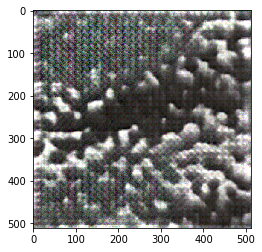

In [69]:
res = data_gen[0].data.cpu().permute(1,2,0).numpy().squeeze()
plt.imshow(np.clip(res, 0, 1))

In [25]:
plt.imsave('gan_res.jpg', np.clip(res,0,1))